
# Intraday Strategy (1-Min Grid, Sliding 5-Min Horizon)




## 1) Imports & configuration

In [16]:

import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# --- Thresholds & execution ---
TH_LONG  = 0.501
TH_SHORT = 0.499
EXEC_DELAY_BARS = 1      # execute next 1-minute bar
HOLD_BARS = 5            # 5-minute horizon on 1m grid

# --- Market clock (1-minute bars) ---
RTH_BARS_PER_DAY = 390           # 9:30–16:00 ET
BARS_PER_YEAR    = 252 * RTH_BARS_PER_DAY

# --- Vol targeting ---
ANNUAL_VOL_TARGET = 0.10         # 10% target annualized volatility

# Use a sensible 1-minute half-life (≈1 trading day = 390 bars)
HL_BARS = 390
EWMA_LAMBDA = 0.5**(1/HL_BARS)   # convert half-life -> lambda

# --- Costs (bps = basis points) ---
FEE_BPS = 0.2
DEFAULT_SPREAD_BPS = 1.0         # half-spread default if no NBBO

# --- Leverage cap ---
L_MAX = 3.0                      # set to 1.0 if strict "no leverage"


## 2) Load & prepare the dataframe (expects timestamp_utc, O/H/L/C, volume)

In [17]:

from pathlib import Path

# Primary path (replace if needed)
DATA_PATH = Path("/Users/ken/fins3666_project/Data/SPY_intraday_cleaned.csv")

def load_df():
    if DATA_PATH.exists():
        df = pd.read_csv(DATA_PATH)
    else:
        # Fallback: try to use an in-memory variable created earlier in the session
        if 'SPY_intraday_cleaned_df' in globals():
            df = SPY_intraday_cleaned_df.copy()
        else:
            raise FileNotFoundError("No CSV at /mnt/data/SPY_intraday_cleaned.csv and no SPY_intraday_cleaned_df in memory.")
    # Ensure timestamp
    if "timestamp_utc" in df.columns:
        df["timestamp_utc"] = pd.to_datetime(df["timestamp_utc"])
        df = df.set_index("timestamp_utc")
    else:
        # If already indexed properly, assume it's datetime
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("Need a datetime 'timestamp_utc' column or a DatetimeIndex.")
    df = df.sort_index()
    return df

df = load_df()

# Confirm 1-minute grid (median spacing ~60s)
bar_secs = df.index.to_series().diff().dt.total_seconds().median()
if pd.notna(bar_secs):
    print("Median bar seconds:", round(bar_secs))
else:
    print("Warning: cannot infer bar spacing")

# Compute 1-minute returns
df["ret_1m"] = df["close"].pct_change().fillna(0.0)

print(df.dtypes.head())
print("Rows:", len(df))
df.head()


Median bar seconds: 60
open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object
Rows: 184552


,open,high,low,close,volume,vwap,ret,vol_5m,vol_30m,ret_1m
timestamp_utc,,,,,,,,,,
2024-01-02 14:30:00+00:00,472.160,472.67,472.050,472.5300,1190522.0,472.9271,0.000784,0.000401,0.000267,0.000000
2024-01-02 14:31:00+00:00,472.530,472.70,472.365,472.6812,756655.0,473.3993,0.000320,0.000404,0.000272,0.000320
2024-01-02 14:32:00+00:00,472.680,472.80,472.650,472.7800,693889.0,473.6179,0.000209,0.000376,0.000268,0.000209
2024-01-02 14:33:00+00:00,472.760,472.77,472.480,472.6900,404264.0,472.6133,-0.000190,0.000363,0.000262,-0.000190
2024-01-02 14:34:00+00:00,472.685,472.78,472.550,472.6700,250698.0,472.6734,-0.000042,0.000376,0.000228,-0.000042


## 3) Rolling features (1-minute bars; 15m/30m/60m windows)

In [18]:

# Rolling returns
df["ret_15m"] = df["close"].pct_change(15)
df["ret_30m"] = df["close"].pct_change(30)

# Volatility from log returns
df["log_ret"]  = np.log(df["close"]).diff()
df["vol_15m"]  = df["log_ret"].rolling(15).std()
df["vol_60m"]  = df["log_ret"].rolling(60).std()

# Trend: 1h & 5h
df["MA_short"] = df["close"].rolling(60).mean()
df["MA_long"]  = df["close"].rolling(300).mean()
df["MA_ratio"] = df["MA_short"] / df["MA_long"]

# Time features
df["minute_of_day"] = df.index.hour*60 + df.index.minute
df["mod_sin"] = np.sin(2*np.pi*df["minute_of_day"]/1440)
df["mod_cos"] = np.cos(2*np.pi*df["minute_of_day"]/1440)
df["dow"]     = df.index.dayofweek
df["dow_sin"] = np.sin(2*np.pi*df["dow"]/7)
df["dow_cos"] = np.cos(2*np.pi*df["dow"]/7)


## 4) Probabilities for next-5m move (p_up_5m or fallback)

In [19]:
# --- Robust probability sourcing / fallback ---
DEFAULT_PROB = 0.502417088

# try common names; otherwise create one
candidates = [c for c in ["p_up_5m","p_up_raw_5m","prob_up","proba_up"] if c in df.columns]
prob_col = candidates[0] if candidates else "p_up_5m"

if not candidates:
    print(f"WARNING: no probability column found — creating '{prob_col}' filled with {DEFAULT_PROB}")
    df[prob_col] = DEFAULT_PROB
else:
    df[prob_col] = pd.to_numeric(df[prob_col], errors="coerce").fillna(DEFAULT_PROB)

# keep in [0,1], and forward-fill if probs arrive at 5-min boundaries
df[prob_col] = df[prob_col].clip(0.0, 1.0).ffill(limit=5)

# quick sanity
nuniq = df[prob_col].nunique(dropna=False)
print(f"Using column: {prob_col}; unique values: {nuniq}")
if nuniq == 1:
    print("NOTE: constant probabilities. With TH_LONG=0.55 / TH_SHORT=0.45 you’ll be flat (no trades). "
          "For a smoke test, temporarily set TH_LONG=0.501, TH_SHORT=0.499 or use sign(prob-0.5).")


Using column: p_up_5m; unique values: 1
NOTE: constant probabilities. With TH_LONG=0.55 / TH_SHORT=0.45 you’ll be flat (no trades). For a smoke test, temporarily set TH_LONG=0.501, TH_SHORT=0.499 or use sign(prob-0.5).


## 5) Signals (thresholds), next-bar execution, K=5-bar hold

In [20]:

# Discrete signal from probabilities
sig = np.where(df[prob_col] >= TH_LONG, 1, np.where(df[prob_col] <= TH_SHORT, -1, 0)).astype(int)
df["signal"] = sig

# Next-bar execution (no look-ahead)
df["signal_exec"] = df["signal"].shift(EXEC_DELAY_BARS).fillna(0).astype(int)

# Hold non-zero signal for exactly K bars
def hold_bars(sig_series, k=HOLD_BARS):
    out = np.zeros(len(sig_series), dtype=int)
    s = sig_series.to_numpy(); i = 0
    while i < len(s):
        if s[i] != 0:
            out[i:i+k] = s[i]
            i += k
        else:
            i += 1
    return pd.Series(out, index=sig_series.index)

df["raw_position"] = hold_bars(df["signal_exec"], HOLD_BARS)  # in {-1,0,+1}
df[["signal","signal_exec","raw_position"]].head(12)


,signal,signal_exec,raw_position
timestamp_utc,,,
2024-01-02 14:30:00+00:00,1,0,0
2024-01-02 14:31:00+00:00,1,1,1
2024-01-02 14:32:00+00:00,1,1,1
2024-01-02 14:33:00+00:00,1,1,1
2024-01-02 14:34:00+00:00,1,1,1
2024-01-02 14:35:00+00:00,1,1,1
2024-01-02 14:36:00+00:00,1,1,1
2024-01-02 14:37:00+00:00,1,1,1
2024-01-02 14:38:00+00:00,1,1,1


## 6) EWMA volatility (1m) → annualized; inverse-vol sizing

In [21]:

# EWMA variance and annualized volatility
ewvar = df["ret_1m"].pow(2).ewm(alpha=(1 - EWMA_LAMBDA)).mean()
bar_vol = np.sqrt(ewvar)
ann_vol = bar_vol * np.sqrt(BARS_PER_YEAR)
df["ann_vol"] = ann_vol

# Inverse-volatility sizing; leverage capped by L_MAX
scale = (ANNUAL_VOL_TARGET / df["ann_vol"]).clip(lower=0.0, upper=L_MAX).fillna(0.0)
df["position"] = df["raw_position"] * scale
df[["ann_vol","position"]].head(12)


,ann_vol,position
timestamp_utc,,
2024-01-02 14:30:00+00:00,0.000000,0.000000
2024-01-02 14:31:00+00:00,0.070963,1.409182
2024-01-02 14:32:00+00:00,0.069195,1.445182
2024-01-02 14:33:00+00:00,0.066937,1.493942
2024-01-02 14:34:00+00:00,0.060138,1.662843
2024-01-02 14:35:00+00:00,0.055142,1.813515
2024-01-02 14:36:00+00:00,0.051168,1.954365
2024-01-02 14:37:00+00:00,0.061607,1.623201
2024-01-02 14:38:00+00:00,0.104231,0.959403


## 7) Costs, P&L, and equity curve

In [22]:

# Turnover & transaction costs (commissions + half-spread)
df["turnover"] = df["position"].diff().abs().fillna(0.0)
fee = FEE_BPS/1e4
half_spread = (DEFAULT_SPREAD_BPS/1e4)
tx_cost = df["turnover"] * (fee + half_spread)

# Net bar P&L (return units)
df["pnl_net"] = df["position"].shift(1).fillna(0.0) * df["ret_1m"] - tx_cost

# Equity curve (start at 1.0)
df["equity"] = (1 + df["pnl_net"]).cumprod()
df[["turnover","pnl_net","equity"]].head()


,turnover,pnl_net,equity
timestamp_utc,,,
2024-01-02 14:30:00+00:00,0.000000,0.000000,1.000000
2024-01-02 14:31:00+00:00,1.409182,-0.000169,0.999831
2024-01-02 14:32:00+00:00,0.036000,0.000290,1.000121
2024-01-02 14:33:00+00:00,0.048760,-0.000281,0.999840
2024-01-02 14:34:00+00:00,0.168901,-0.000083,0.999757


## 8) Performance analytics (Sharpe, Sortino, MaxDD, CAGR, alpha/beta/corr, trades)

In [23]:

ann = BARS_PER_YEAR
bar_rets = df["pnl_net"].astype(float)

def ann_return(x): return x.mean()*ann
def ann_vol(x):    return x.std(ddof=1)*np.sqrt(ann)
def sharpe(x):     return np.nan if ann_vol(x)==0 else ann_return(x)/ann_vol(x)
def sortino(x):
    dn = x[x<0].std(ddof=1)*np.sqrt(ann)
    return np.nan if dn==0 else ann_return(x)/dn
def max_dd(eq):
    peak = eq.cummax()
    return float((eq/peak - 1.0).min())

years = len(df)/ann
cagr  = float(df["equity"].iloc[-1]**(1/years) - 1.0) if years>0 else np.nan

# Benchmark = underlying 1m return
bench = df["ret_1m"].astype(float)
beta = (np.cov(bar_rets, bench)[0,1] / np.var(bench)) if bench.var()>0 else np.nan
alpha_ann = (bar_rets.mean() - (beta * bench.mean()))*ann if np.isfinite(beta) else np.nan
corr = np.corrcoef(bar_rets, bench)[0,1] if bench.std(ddof=1)>0 else np.nan

# Simple K-bar trade count & win rate (bar-level win rate)
trades_kbar = int((df["raw_position"].diff().fillna(0)!=0).sum()//2)
win_rate_bar = float((bar_rets>0).mean())

perf = pd.Series({
    "Total Return": float(df["equity"].iloc[-1]-1),
    "CAGR": cagr,
    "Ann.Return": float(ann_return(bar_rets)),
    "Ann.Vol": float(ann_vol(bar_rets)),
    "Sharpe": float(sharpe(bar_rets)),
    "Sortino": float(sortino(bar_rets)),
    "MaxDD": float(max_dd(df["equity"])),
    "Trades (K-bar)": trades_kbar,
    "Win Rate (bar)": win_rate_bar,
    "Alpha (ann.)": float(alpha_ann) if np.isfinite(alpha_ann) else np.nan,
    "Beta": float(beta) if np.isfinite(beta) else np.nan,
    "Corr w/ Benchmark": float(corr) if np.isfinite(corr) else np.nan
})
display(perf.to_frame("Value"))


,Value
Total Return,0.237119
CAGR,0.119985
Ann.Return,0.119903
Ann.Vol,0.114734
Sharpe,1.045055
Sortino,1.190796
MaxDD,-0.153078
Trades (K-bar),0.000000
Win Rate (bar),0.474116
Alpha (ann.),-0.003854


## 9) Equity curve, turnover, capacity, and distributions

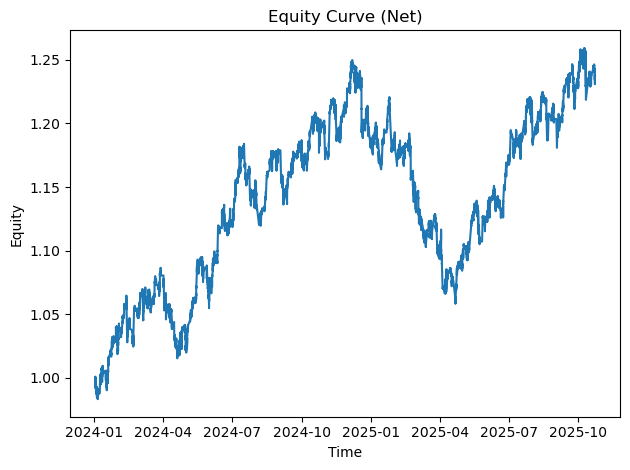

Total turnover: 222.49388810802935
Avg daily turnover: 0.4713853561610791


,USD
Cap_min,1.666536e+05
Cap_p05,6.568864e+07
Cap_median,3.302846e+09


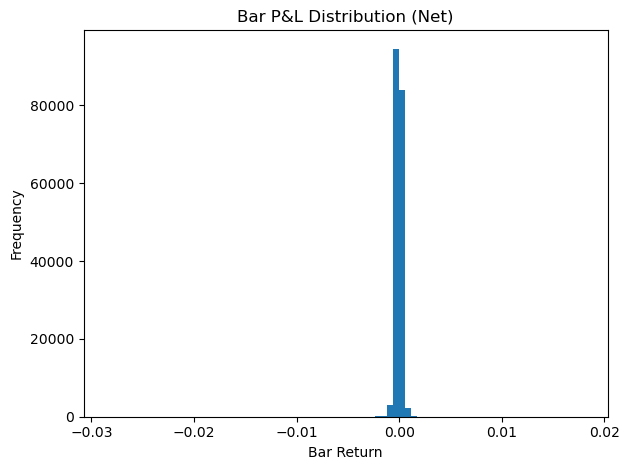

In [24]:

# Equity curve
plt.figure()
plt.plot(df.index, df["equity"])
plt.title("Equity Curve (Net)"); plt.xlabel("Time"); plt.ylabel("Equity")
plt.tight_layout(); plt.show()

# Turnover summary
daily_turnover = df["turnover"].resample("1D").sum(min_count=1)
print("Total turnover:", df["turnover"].sum())
print("Avg daily turnover:", daily_turnover.mean())

# Capacity via participation cap (uses vwap_5m if available; else close)
PARTICIPATION_CAP = 0.05  # 5%
price_for_dv = df.get("vwap_5m", df["close"])
dollar_vol = price_for_dv * df["volume"]
cap_per_bar = (PARTICIPATION_CAP * dollar_vol) / df["turnover"].replace(0, np.nan)
cap_per_bar = cap_per_bar.replace([np.inf, -np.inf], np.nan)
cap_summary = pd.Series({
    "Cap_min": np.nanmin(cap_per_bar.values),
    "Cap_p05": np.nanpercentile(cap_per_bar.dropna(), 5) if cap_per_bar.notna().any() else np.nan,
    "Cap_median": np.nanmedian(cap_per_bar.values),
})
display(cap_summary.to_frame("USD"))

# Bar P&L distribution
plt.figure()
plt.hist(df["pnl_net"].dropna(), bins=80)
plt.title("Bar P&L Distribution (Net)"); plt.xlabel("Bar Return"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()


## 10) Trade ledger & holding-period distribution (K=5 bars)

,t_entry,t_exit,i_entry,i_exit,side,hp_bars,hp_minutes,pnl_gross
0,2024-01-02 14:31:00+00:00,2024-01-02 14:35:00+00:00,1,5,1,5,5,0.000254


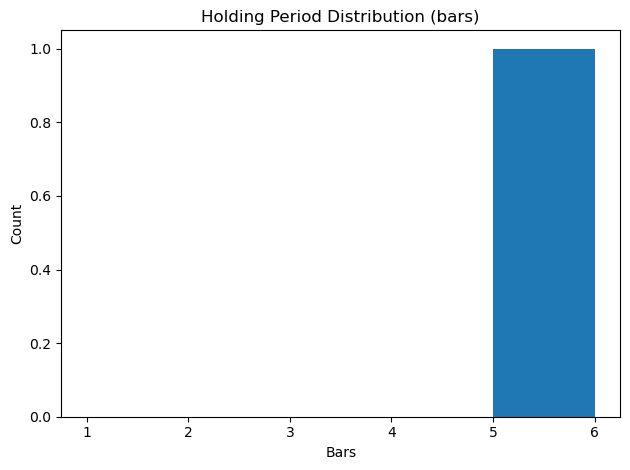

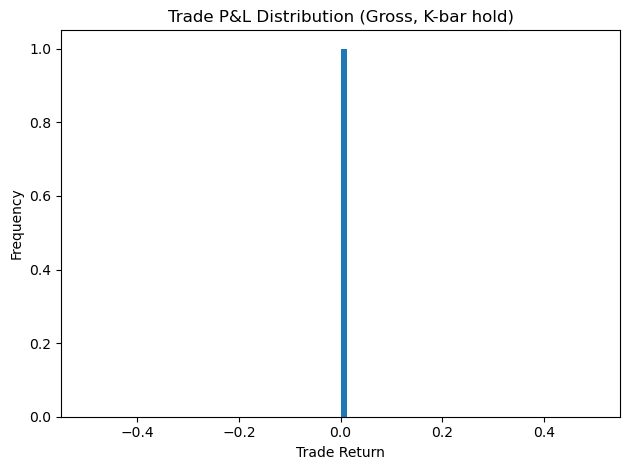

In [25]:

trades = []
pos = df["raw_position"].fillna(0).astype(int).to_numpy()
i = 0
while i < len(pos):
    if pos[i] != 0 and (i == 0 or pos[i-1] == 0):
        side = 1 if pos[i] > 0 else -1
        j = min(i + HOLD_BARS - 1, len(pos)-1)
        px_in  = df["close"].iloc[i-1] if i>0 else df["open"].iloc[i]
        px_out = df["close"].iloc[j]
        pnl_gross = side * (px_out/px_in - 1.0)
        trades.append({
            "t_entry": df.index[i], "t_exit": df.index[j],
            "i_entry": i, "i_exit": j, "side": side,
            "hp_bars": int(j-i+1), "hp_minutes": int(j-i+1),
            "pnl_gross": float(pnl_gross),
        })
        i = j + 1
    else:
        i += 1

trades_ledger = pd.DataFrame(trades)
display(trades_ledger.head())

if not trades_ledger.empty:
    plt.figure()
    plt.hist(trades_ledger["hp_bars"], bins=range(1, trades_ledger["hp_bars"].max()+2))
    plt.title("Holding Period Distribution (bars)"); plt.xlabel("Bars"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

    plt.figure()
    plt.hist(trades_ledger["pnl_gross"], bins=80)
    plt.title("Trade P&L Distribution (Gross, K-bar hold)"); plt.xlabel("Trade Return"); plt.ylabel("Frequency")
    plt.tight_layout(); plt.show()
else:
    print("No trades identified for holding-period analysis.")
